# Carregar modelo

In [1]:
from keras.models import load_model

backtestDays = 21
daysCandles = 114
modelo = load_model('models/TransferLearningmodel4.h5')
modelo.summary()




Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 501, 6, 1)]          0         []                            
                                                                                                  
 cropping2d_1 (Cropping2D)   (None, 486, 6, 1)            0         ['input_2[0][0]']             
                                                                                                  
 reshape_1 (Reshape)         (None, 54, 54, 1)            0         ['cropping2d_1[0][0]']        
                                                                                                  
 concatenate_1 (Concatenate  (None, 54, 54, 3)            0         ['reshape_1[0][0]',           
 )                                                                   'reshape_1[0][0]',    

# Teste Finaceiro

In [2]:
from json import dumps
from tqdm import tqdm
import numpy as np
from obterDados import obterSimboloPosicao, obterSimboloData

target = 30
stop = 10
timeLimit = 24
total = 0
long = False
short = False
position = 0
candle = -1
trade_summary = {
    'longSuccess' : [0, 0],
    'longFail' : [0, 0],
    'longEndSuccess' : [0, 0],
    'longEndFail' : [0, 0],
    'shortSuccess' : [0, 0],
    'shortFail' : [0, 0],
    'shortEndSuccess' : [0, 0],
    'shortEndFail' : [0, 0],
}
buys_and_sells = []
for i in tqdm(range(backtestDays*daysCandles, -1, -1)):
    histM5 = obterSimboloPosicao('WDO$N', n=300, delayCandles=i)
    histM5['minute'] = histM5.index.minute
    histM5['hour'] = histM5.index.hour
    histM5['day_of_week'] = histM5.index.day_of_week
    histM5['day'] = histM5.index.day
    histM5NP = histM5.to_numpy()
    hist = np.zeros((501, 6))
    hist[0, -4:] = histM5NP[-1][-4:]
    hist[1:301] = histM5NP[:, :6]
    histD1 = obterSimboloData(histM5.index[-1])
    histD1NP = histD1.to_numpy()
    hist[301:] = histD1NP
    vmax = hist[1:301, :4].max()
    vmin = hist[1:301, :4].min()
    hist[1:301, :4] = (hist[1:301, :4] - vmin) / (vmax - vmin)
    vmax = hist[1:301, 4].max()
    vmin = hist[1:301, 4].min()
    hist[1:301, 4] = (hist[1:301, 4] - vmin) / (vmax - vmin)
    vmax = hist[1:301, 5].max()
    vmin = hist[1:301, 5].min()
    hist[1:301, 5] = (hist[1:301, 5] - vmin) / (vmax - vmin)
    vmax = hist[301:, :4].max()
    vmin = hist[301:, :4].min()
    hist[301:, :4] = (hist[301:, :4] - vmin) / (vmax - vmin)
    vmax = hist[301:, 4].max()
    vmin = hist[301:, 4].min()
    hist[301:, 4] = (hist[301:, 4] - vmin) / (vmax - vmin)
    vmax = hist[301:, 5].max()
    vmin = hist[301:, 5].min()
    hist[301:, 5] = (hist[301:, 5] - vmin) / (vmax - vmin)
    hist[0, 2] /= 60
    hist[0, 3] /= 24
    hist[0, 4] /= 4
    hist[0, 5] /= 31
    priceNow = histM5['close'].iloc[-1]
    if long:
        if priceNow >= position + target:
            total += priceNow - position
            long = False
            trade_summary['longSuccess'][0] += 1
            trade_summary['longSuccess'][1] += priceNow - position
        if priceNow <= position - stop:
            total += priceNow - position
            long = False
            trade_summary['longFail'][0] += 1
            trade_summary['longFail'][1] += priceNow - position
        if i >= candle + timeLimit:
            total += priceNow - position
            long = False
            if priceNow - position > 0:
                trade_summary['longEndSuccess'][0] += 1
                trade_summary['longEndSuccess'][1] += priceNow - position
            else:
                trade_summary['longEndFail'][0] += 1
                trade_summary['longEndFail'][1] += priceNow - position
        if not long:
            buys_and_sells.append([i, 'Close', priceNow])
        continue
    if short:
        if priceNow <= position - target:
            total += position - priceNow
            short = False
            trade_summary['shortSuccess'][0] += 1
            trade_summary['shortSuccess'][1] += position - priceNow
        if priceNow >= position + stop:
            total += position - priceNow
            short = False
            trade_summary['shortFail'][0] += 1
            trade_summary['shortFail'][1] += position - priceNow
        if i >= candle + timeLimit:
            total += position - priceNow
            short = False
            if position - priceNow > 0:
                trade_summary['shortEndSuccess'][0] += 1
                trade_summary['shortEndSuccess'][1] += position - priceNow
            else:
                trade_summary['shortEndFail'][0] += 1
                trade_summary['shortEndFail'][1] += position - priceNow
        if not short:
            buys_and_sells.append([i, 'Close', priceNow])
        continue

    previsao = np.argmax(modelo.predict(np.array([hist]), verbose=0)[0])
    if previsao == 1:
        long = True
        position = priceNow
        candle = i
        buys_and_sells.append([i, 'Buy', priceNow])
    if previsao == 2:
        short = True
        position = priceNow
        candle = i
        buys_and_sells.append([i, 'Sell', priceNow])

print('Total:', total)
# print('Operações: ', dumps(trade_summary, indent=4))

100%|██████████| 2395/2395 [00:59<00:00, 40.34it/s]

Total: -33.0


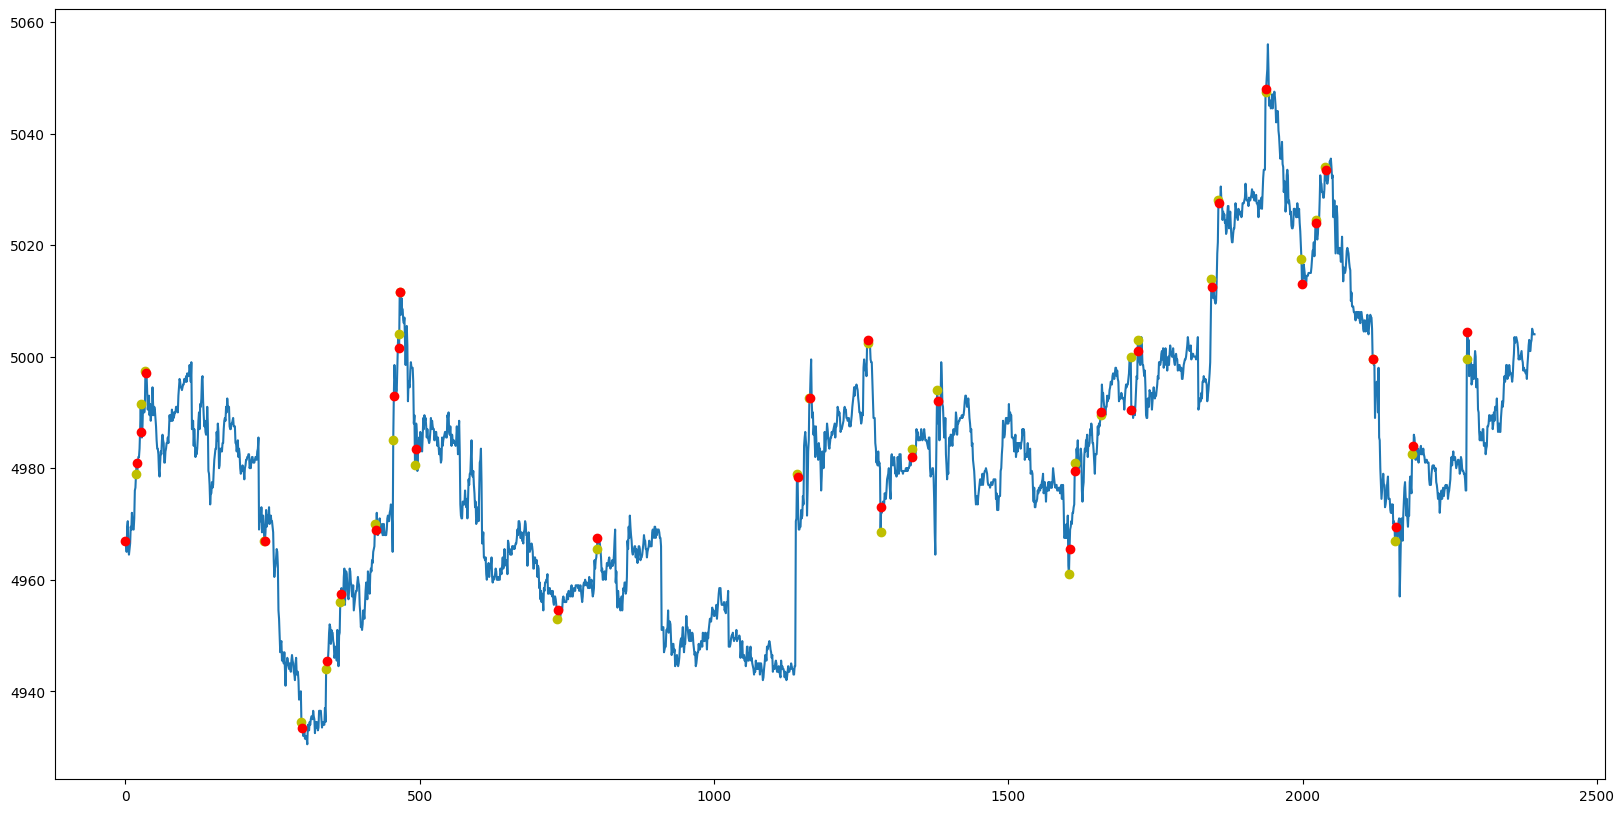

In [3]:
from matplotlib import pyplot as plt

plt.figure(figsize=(20, 10))
plt.plot(obterSimboloPosicao('WDO$N', n=backtestDays*daysCandles+1)['close'].to_numpy())
for idx, action, price in buys_and_sells:
    if action == 'Buy':
        plt.plot(-idx+backtestDays*daysCandles, price, 'o', color='g')
    if action == 'Sell':
        plt.plot(-idx+backtestDays*daysCandles, price, 'o', color='r')
    if action == 'Close':
        plt.plot(-idx+backtestDays*daysCandles, price, 'o', color='y')
plt.show()